In [ ]:
# Install dependencies
!pip install --quiet kaggle
!pip install --quiet segmentation-models-pytorch --no-deps
!pip install --quiet albumentations
!pip install --quiet matplotlib scikit-learn
print("Libraries installed sucessfully !")

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 154.8/154.8 kB 7.2 MB/s eta 0:00:00
Libraries installed sucessfully !


In [ ]:
from google.colab import files
import os

# Upload kaggle.json
print("Upload kaggle.json file:")
files.upload()

# Setup kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




Upload kaggle.json file:


Saving kaggle.json to kaggle.json


In [ ]:
# Download dataset
# REPLACE with your actual dataset slug
dataset_slug = "omendrakumarupadhyay/crack-segmentation-datasetimage-mask"
!kaggle datasets download -d {dataset_slug}


Dataset URL: https://www.kaggle.com/datasets/omendrakumarupadhyay/crack-segmentation-datasetimage-mask
License(s): CC0-1.0


In [ ]:
!unzip -q *.zip -d Crack_Dataset
print("Dataset downloaded and extracted.")

Dataset downloaded and extracted.


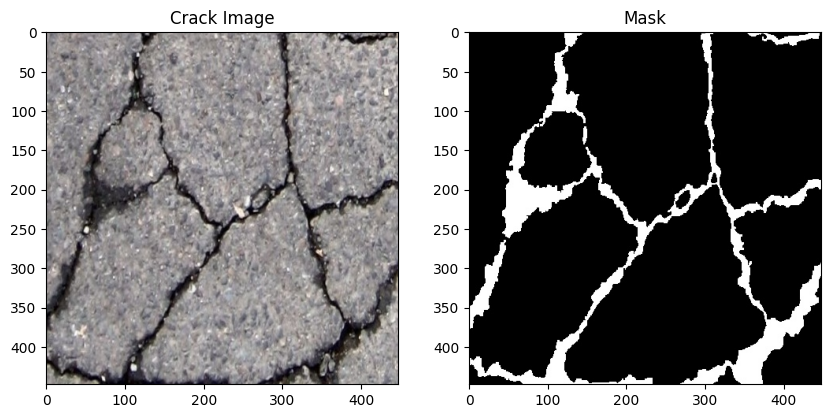

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import glob

image_paths = sorted(glob.glob('Crack_Dataset/Complete Dataset/images/*.jpg'))
mask_paths = sorted(glob.glob('Crack_Dataset/Complete Dataset/masks/*.jpg'))

idx = random.randint(0, len(image_paths)-1)
image = Image.open(image_paths[idx])
mask = Image.open(mask_paths[idx])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Crack Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()


Check all images and masks resolution

In [ ]:
sizes = set()
for img_path, mask_path in zip(image_paths, mask_paths):
    img_size = Image.open(img_path).size
    mask_size = Image.open(mask_path).size
    sizes.add((img_size, mask_size))

print(f"Unique (Image, Mask) sizes found: {len(sizes)}")
print(sizes)


Unique (Image, Mask) sizes found: 1
{((448, 448), (448, 448))}


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CrackDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [ ]:
# 80% Train, 10% Val, 10% Test
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42
)

train_loader = DataLoader(CrackDataset(train_imgs, train_masks, transform), batch_size=8, shuffle=True)
val_loader = DataLoader(CrackDataset(val_imgs, val_masks, transform), batch_size=8, shuffle=False)
test_loader = DataLoader(CrackDataset(test_imgs, test_masks, transform), batch_size=8, shuffle=False)

print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")


Train: 9038, Val: 1130, Test: 1130


In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.PSPNet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm
epochs=50
# Create checkpoint directory in Google Drive
checkpoint_dir = "/content/drive/MyDrive/CS_PSPnet_checkpoints/"
os.makedirs(checkpoint_dir, exist_ok=True)

train_losses = []
val_losses = []

print("üöÄ Starting training...\n")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    val_loss = 0

    print(f"\nüìò Epoch {epoch+1}/{epochs}")
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for images, masks in train_loader_tqdm:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"‚úÖ Training loss: {avg_train_loss:.4f}")

    # Validation step
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"üîç Validation loss: {avg_val_loss:.4f}")

    # Save model checkpoint
    checkpoint_path = f"{checkpoint_dir}/pspnet_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"üíæ Model checkpoint saved at: {checkpoint_path}")


üöÄ Starting training...


üìò Epoch 1/50


‚úÖ Training loss: 0.0883
üîç Validation loss: 0.0710
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_1.pth

üìò Epoch 2/50


‚úÖ Training loss: 0.0661
üîç Validation loss: 0.0647
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_2.pth

üìò Epoch 3/50


‚úÖ Training loss: 0.0617
üîç Validation loss: 0.0626
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_3.pth

üìò Epoch 4/50


‚úÖ Training loss: 0.0585
üîç Validation loss: 0.0617
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_4.pth

üìò Epoch 5/50


‚úÖ Training loss: 0.0563
üîç Validation loss: 0.0589
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_5.pth

üìò Epoch 6/50


‚úÖ Training loss: 0.0542
üîç Validation loss: 0.0584
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_6.pth

üìò Epoch 7/50


‚úÖ Training loss: 0.0526
üîç Validation loss: 0.0584
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_7.pth

üìò Epoch 8/50


‚úÖ Training loss: 0.0510
üîç Validation loss: 0.0575
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_8.pth

üìò Epoch 9/50


‚úÖ Training loss: 0.0498
üîç Validation loss: 0.0568
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_9.pth

üìò Epoch 10/50


‚úÖ Training loss: 0.0486
üîç Validation loss: 0.0566
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_10.pth

üìò Epoch 11/50


‚úÖ Training loss: 0.0475
üîç Validation loss: 0.0580
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_11.pth

üìò Epoch 12/50


‚úÖ Training loss: 0.0468
üîç Validation loss: 0.0586
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_12.pth

üìò Epoch 13/50


‚úÖ Training loss: 0.0458
üîç Validation loss: 0.0575
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_13.pth

üìò Epoch 14/50


‚úÖ Training loss: 0.0449
üîç Validation loss: 0.0582
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_14.pth

üìò Epoch 15/50


‚úÖ Training loss: 0.0443
üîç Validation loss: 0.0574
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_15.pth

üìò Epoch 16/50


‚úÖ Training loss: 0.0438
üîç Validation loss: 0.0590
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_16.pth

üìò Epoch 17/50


‚úÖ Training loss: 0.0429
üîç Validation loss: 0.0577
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_17.pth

üìò Epoch 18/50


‚úÖ Training loss: 0.0425
üîç Validation loss: 0.0592
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_18.pth

üìò Epoch 19/50


‚úÖ Training loss: 0.0419
üîç Validation loss: 0.0620
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_19.pth

üìò Epoch 20/50


‚úÖ Training loss: 0.0416
üîç Validation loss: 0.0592
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_20.pth

üìò Epoch 21/50


‚úÖ Training loss: 0.0409
üîç Validation loss: 0.0627
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_21.pth

üìò Epoch 22/50


‚úÖ Training loss: 0.0407
üîç Validation loss: 0.0626
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_22.pth

üìò Epoch 23/50


‚úÖ Training loss: 0.0404
üîç Validation loss: 0.0645
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_23.pth

üìò Epoch 24/50


‚úÖ Training loss: 0.0396
üîç Validation loss: 0.0643
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_24.pth

üìò Epoch 25/50


‚úÖ Training loss: 0.0394
üîç Validation loss: 0.0647
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_25.pth

üìò Epoch 26/50


‚úÖ Training loss: 0.0391
üîç Validation loss: 0.0610
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_26.pth

üìò Epoch 27/50


‚úÖ Training loss: 0.0389
üîç Validation loss: 0.0623
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_27.pth

üìò Epoch 28/50


‚úÖ Training loss: 0.0383
üîç Validation loss: 0.0691
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_28.pth

üìò Epoch 29/50


‚úÖ Training loss: 0.0381
üîç Validation loss: 0.0666
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_29.pth

üìò Epoch 30/50


‚úÖ Training loss: 0.0378
üîç Validation loss: 0.0705
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_30.pth

üìò Epoch 31/50


‚úÖ Training loss: 0.0377
üîç Validation loss: 0.0626
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_31.pth

üìò Epoch 32/50


‚úÖ Training loss: 0.0375
üîç Validation loss: 0.0671
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_32.pth

üìò Epoch 33/50


‚úÖ Training loss: 0.0371
üîç Validation loss: 0.0645
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_33.pth

üìò Epoch 34/50


‚úÖ Training loss: 0.0368
üîç Validation loss: 0.0660
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_34.pth

üìò Epoch 35/50


‚úÖ Training loss: 0.0366
üîç Validation loss: 0.0715
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_35.pth

üìò Epoch 36/50


‚úÖ Training loss: 0.0363
üîç Validation loss: 0.0645
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_36.pth

üìò Epoch 37/50


‚úÖ Training loss: 0.0362
üîç Validation loss: 0.0688
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_37.pth

üìò Epoch 38/50


‚úÖ Training loss: 0.0361
üîç Validation loss: 0.0662
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_38.pth

üìò Epoch 39/50


‚úÖ Training loss: 0.0359
üîç Validation loss: 0.0703
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_39.pth

üìò Epoch 40/50


‚úÖ Training loss: 0.0358
üîç Validation loss: 0.0722
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_40.pth

üìò Epoch 41/50


‚úÖ Training loss: 0.0354
üîç Validation loss: 0.0717
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_41.pth

üìò Epoch 42/50


‚úÖ Training loss: 0.0353
üîç Validation loss: 0.0727
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_42.pth

üìò Epoch 43/50


‚úÖ Training loss: 0.0351
üîç Validation loss: 0.0727
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_43.pth

üìò Epoch 44/50


‚úÖ Training loss: 0.0348
üîç Validation loss: 0.0703
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_44.pth

üìò Epoch 45/50


‚úÖ Training loss: 0.0348
üîç Validation loss: 0.0711
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_45.pth

üìò Epoch 46/50


‚úÖ Training loss: 0.0346
üîç Validation loss: 0.0714
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_46.pth

üìò Epoch 47/50


‚úÖ Training loss: 0.0345
üîç Validation loss: 0.0731
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_47.pth

üìò Epoch 48/50


‚úÖ Training loss: 0.0344
üîç Validation loss: 0.0746
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_48.pth

üìò Epoch 49/50


‚úÖ Training loss: 0.0342
üîç Validation loss: 0.0758
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_49.pth

üìò Epoch 50/50


‚úÖ Training loss: 0.0341
üîç Validation loss: 0.0751
üíæ Model checkpoint saved at: /content/drive/MyDrive/CS_PSPnet_checkpoints//pspnet_epoch_50.pth


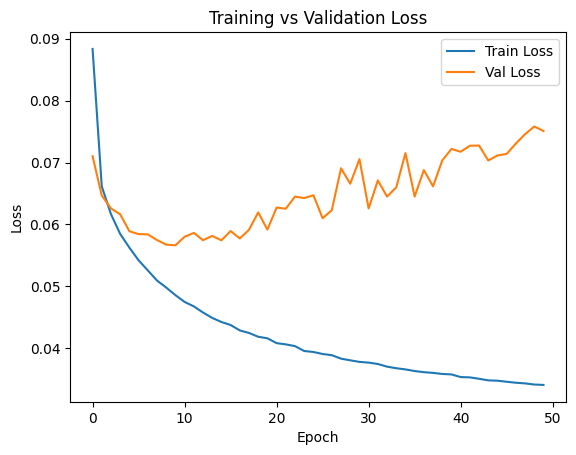

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    jaccard_score,
)

# Suppose preds and masks are already available from model inference
preds = torch.sigmoid(preds)           # Ensure values between 0 and 1
preds = (preds > 0.5).float()          # Convert to binary mask

# Flatten predictions and targets
y_true = masks.cpu().numpy().flatten()
y_pred = preds.cpu().numpy().flatten()

# Convert to integers
y_true = y_true.astype(int)
y_pred = y_pred.astype(int)

# Now calculate metrics
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("IoU Score:", jaccard_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))


Confusion Matrix:
 [[89219 41331]
 [  509    13]]
IoU Score: 0.0003106109478412539
Precision: 0.00031443498452012384
Recall: 0.02490421455938697
F1 Score: 0.0006210289972770267
Accuracy: 0.6807861328125


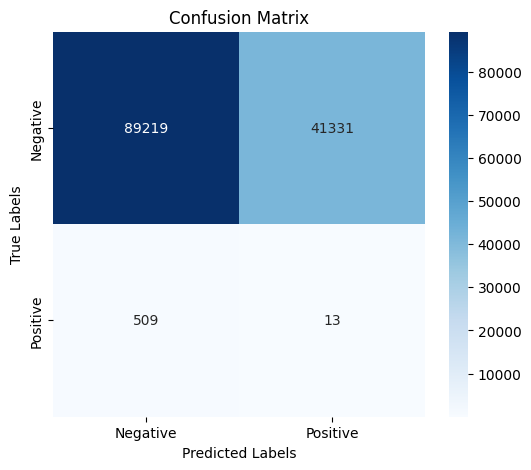

Accuracy: 0.6808
Precision: 0.0003
Recall: 0.0249
F1 Score: 0.0006
IoU (Jaccard Index): 0.0003


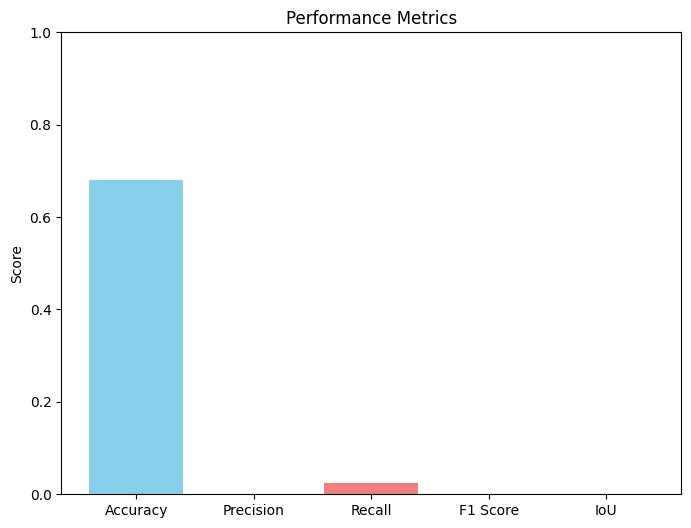

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Provided values
cm = np.array([[89219, 41331],
               [  509,    13]])

iou = 0.0003106109478412539
precision = 0.00031443498452012384
recall = 0.02490421455938697
f1 = 0.0006210289972770267
accuracy = 0.6807861328125

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU (Jaccard Index): {iou:.4f}")

# Optional: Plot performance metrics in a bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'IoU']
values = [accuracy, precision, recall, f1, iou]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightgoldenrodyellow'])
plt.ylim(0, 1)
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.show()


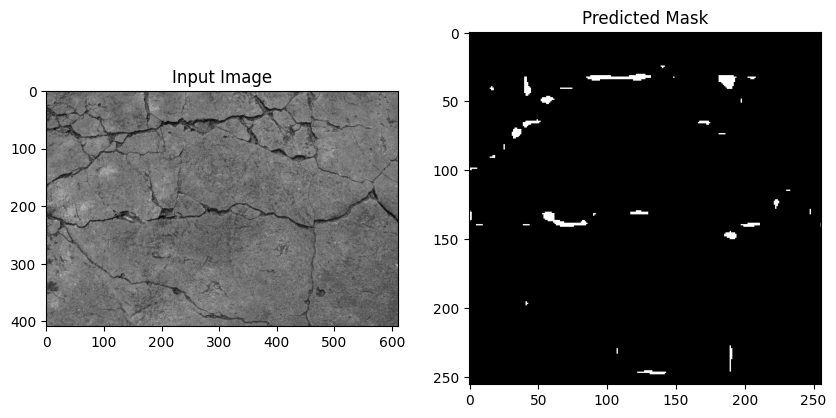

In [ ]:
def predict_mask(image_path, model, device):
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Predict mask
    with torch.no_grad():
        output = model(img_tensor)
        pred_mask = (output.squeeze().cpu().numpy() > 0.5).astype('float32')

    # Show input and predicted mask
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

# Use it like this (replace with your own image path if needed):
predict_mask("/content/sample 3.jpg", model, device) # Repalce input image path


In [ ]:
# Save final model after training
torch.save(model.state_dict(), "pspnet_trained_model.pth")
print("‚úÖ Model saved as pspnet_trained_model.pth")


‚úÖ Model saved as pspnet_trained_model.pth


In [ ]:
from google.colab import files
files.download("pspnet_trained_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>